In [4]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

Model loaded successfully!
Skipping image 1, predicted class does not match LIME label.
Skipping image 2, predicted class does not match LIME label.
Skipping image 3, predicted class does not match LIME label.
Skipping image 4, predicted class does not match LIME label.
Skipping image 5, predicted class does not match LIME label.
Skipping image 6, predicted class does not match LIME label.
Skipping image 7, predicted class does not match LIME label.
Skipping image 8, predicted class does not match LIME label.
Skipping image 9, predicted class does not match LIME label.
Skipping image 10, predicted class does not match LIME label.
Skipping image 11, predicted class does not match LIME label.
Skipping image 12, predicted class does not match LIME label.
Skipping image 14, predicted class does not match LIME label.
Skipping image 15, predicted class does not match LIME label.
Skipping image 16, predicted class does not match LIME label.
Skipping image 18, predicted class does not match LI

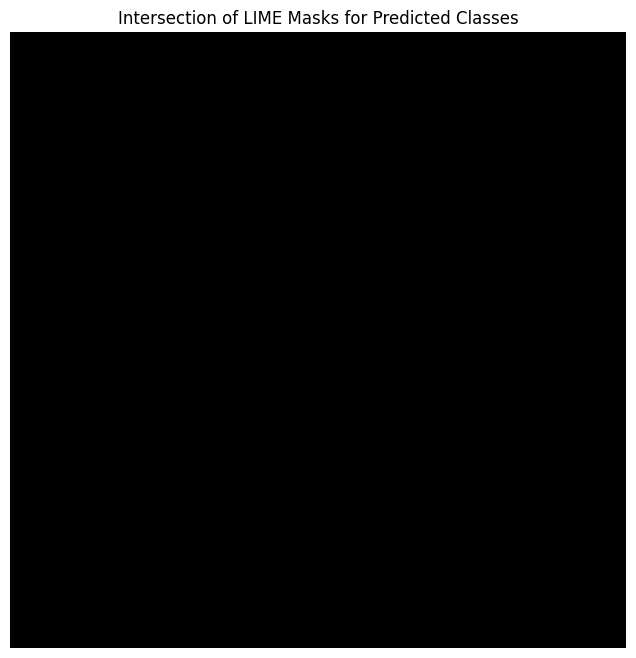

In [5]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()
])

dataset = datasets.Imagenette(root='/home/j597s263/scratch/j597s263/Datasets/imagenette', download=False, transform=transform)

random.seed(42) 
indices = list(range(len(dataset)))
random.shuffle(indices)

# Split shuffled indices into training and testing
train_indices = indices[:7568]
test_indices = indices[7568:8522]
attack_indices = indices[8522:]

# Create Subsets
train_data = Subset(dataset, train_indices)
test_data = Subset(dataset, test_indices)
attack_data = Subset(dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)  # No shuffle for test set
attack_loader = DataLoader(attack_data, batch_size=1, shuffle=False)  # Batch size 1 for mask intersection

# Load the model
model = torch.load('/home/j597s263/scratch/j597s263/Models/ConvModels/Conv_Imagenette.mod', weights_only=False, map_location="cuda:0")
model = model.to('cuda')
model.eval()
print("Model loaded successfully!")

# Load LIME explanations
lime_explanations = np.load("/home/j597s263/scratch/j597s263/Datasets/Explanation_values/lime_ConvImag.npy", allow_pickle=True)  # Replace with the correct path

# Initialize the intersection mask (224x224, all True)
intersection_mask = np.ones((224, 224), dtype=bool)

# Process each image in the attack_loader
for idx, (image_tensor, _) in enumerate(attack_loader):
    image_tensor = image_tensor.to('cuda')  # Move image to device

    # Get model prediction for the current image
    outputs = model(image_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()

    # Get the corresponding LIME explanation
    lime_explanation = lime_explanations[idx]
    mask = lime_explanation['mask']

    # Ensure the mask is for the predicted class
    if lime_explanation['label'] == predicted_class:
        # Update the intersection mask (logical AND)
        intersection_mask = np.logical_and(intersection_mask, mask)
    else:
        print(f"Skipping image {idx}, predicted class does not match LIME label.")

# Visualize the intersection mask
plt.figure(figsize=(8, 8))
plt.imshow(intersection_mask, cmap='gray')
plt.title("Intersection of LIME Masks for Predicted Classes")
plt.axis('off')
plt.show()


In [7]:
# Test with one image from attack_loader
for idx, (image_tensor, _) in enumerate(attack_loader):
    image_tensor = image_tensor.to('cuda')  # Move image to device

    # Get model prediction for the current image
    outputs = model(image_tensor)
    predicted_class = torch.argmax(outputs, dim=1).item()

    # Get the corresponding LIME explanation
    lime_explanation = lime_explanations[idx]
    lime_label = lime_explanation['label']  # Extract the label from the LIME explanation

    # Print the predicted class and LIME label
    print(f"Image {idx} - Predicted Class: {predicted_class}, LIME Label: {lime_label}")

    # Stop after testing one image
    


Image 0 - Predicted Class: 6, LIME Label: 6
Image 1 - Predicted Class: 5, LIME Label: 9
Image 2 - Predicted Class: 0, LIME Label: 1
Image 3 - Predicted Class: 5, LIME Label: 0
Image 4 - Predicted Class: 0, LIME Label: 1
Image 5 - Predicted Class: 0, LIME Label: 6
Image 6 - Predicted Class: 5, LIME Label: 6
Image 7 - Predicted Class: 2, LIME Label: 4
Image 8 - Predicted Class: 7, LIME Label: 4
Image 9 - Predicted Class: 1, LIME Label: 0
Image 10 - Predicted Class: 9, LIME Label: 2
Image 11 - Predicted Class: 7, LIME Label: 0
Image 12 - Predicted Class: 1, LIME Label: 0
Image 13 - Predicted Class: 9, LIME Label: 9
Image 14 - Predicted Class: 4, LIME Label: 6
Image 15 - Predicted Class: 4, LIME Label: 2
Image 16 - Predicted Class: 1, LIME Label: 3
Image 17 - Predicted Class: 0, LIME Label: 0
Image 18 - Predicted Class: 8, LIME Label: 9
Image 19 - Predicted Class: 5, LIME Label: 5
Image 20 - Predicted Class: 6, LIME Label: 9
Image 21 - Predicted Class: 5, LIME Label: 2
Image 22 - Predicted